In [1]:
%pylab inline
import xarray as xr
from tqdm import tqdm_notebook
import cmocean.cm as cmo

plt.rcParams['figure.figsize'] = (18,10)
plt.rcParams['font.size'] = 16
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.direction'] = 'in'

font = {'family' : 'Arial',
        'weight' : 'ultralight',
        'size'   : 16}

matplotlib.rc('font', **font)

rc('ytick.major', size=6)
rc('xtick.major', size=6)
rc('ytick.minor', size=4)
rc('xtick.minor', size=4)
rc('lines', linewidth=2.5)

Populating the interactive namespace from numpy and matplotlib


### Find all the summer profiles that were taken during our the summer (Dec-Mar) from 2010 to 2019

In [2]:
from glob import glob
from tqdm import tqdm
from scipy.interpolate import griddata

flist = sorted(glob('/Users/marcel/Google Drive/Projects/buoyancy_flux_paper/data/EN4.2.1/Profiles_L09_2018_19/*.nc'))

max_lat=-30
min_lat=-70
max_lon= 10
min_lon= -5

dpt = np.arange(0, 1010, 10)

for f, fname in enumerate(flist):
    
    print(fname)
    
    ds = xr.open_dataset(fname)
    
    ind_GH = ((ds.LATITUDE.values<max_lat) & (ds.LATITUDE.values>min_lat) & (ds.LONGITUDE.values>min_lon) & (ds.LONGITUDE.values<max_lon) & (ds.QC_FLAGS_PROFILES.values==0))
    ds = ds.isel(N_PROF=ds.N_PROF[ind_GH].values)
    
    if f==0:
        
        time = ds.JULD
        lats = ds.LATITUDE
        lons = ds.LONGITUDE
        
    if f>0:
        
        time = np.append(time, ds.JULD)
        lats = np.append(lats, ds.LATITUDE)
        lons = np.append(lons, ds.LONGITUDE)
    
    temp_old = ds.TEMP.values
    salt_old = ds.PSAL_CORRECTED.values
    dpt_old  = ds.DEPH_CORRECTED.values
    
    for pr in range(len(temp_old)):
        
        if f==0 and pr==0:
            
            print('first profile')
                        
            temp = griddata(dpt_old[pr], temp_old[pr], dpt)
            salt = griddata(dpt_old[pr], salt_old[pr], dpt)
            
        elif f==0 and pr==1:
            
            print('second profile')
                        
            temp = np.column_stack((temp, griddata(dpt_old[pr], temp_old[pr], dpt)))
            salt = np.column_stack((salt, griddata(dpt_old[pr], salt_old[pr], dpt)))
            
        else:
        
            temp = np.column_stack((temp, griddata(dpt_old[pr], temp_old[pr], dpt)))
            salt = np.column_stack((salt, griddata(dpt_old[pr], salt_old[pr], dpt)))

/Users/marcel/Google Drive/Projects/buoyancy_flux_paper/data/EN4.2.1/Profiles_L09_2018_19/EN.4.2.1.f.profiles.g10.201001.nc
first profile
second profile
/Users/marcel/Google Drive/Projects/buoyancy_flux_paper/data/EN4.2.1/Profiles_L09_2018_19/EN.4.2.1.f.profiles.g10.201002.nc
/Users/marcel/Google Drive/Projects/buoyancy_flux_paper/data/EN4.2.1/Profiles_L09_2018_19/EN.4.2.1.f.profiles.g10.201003.nc
/Users/marcel/Google Drive/Projects/buoyancy_flux_paper/data/EN4.2.1/Profiles_L09_2018_19/EN.4.2.1.f.profiles.g10.201012.nc


/Users/marcel/opt/anaconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:605: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/marcel/opt/anaconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:608: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


/Users/marcel/Google Drive/Projects/buoyancy_flux_paper/data/EN4.2.1/Profiles_L09_2018_19/EN.4.2.1.f.profiles.g10.201101.nc


/Users/marcel/opt/anaconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:605: RuntimeWarning: invalid value encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


/Users/marcel/Google Drive/Projects/buoyancy_flux_paper/data/EN4.2.1/Profiles_L09_2018_19/EN.4.2.1.f.profiles.g10.201102.nc
/Users/marcel/Google Drive/Projects/buoyancy_flux_paper/data/EN4.2.1/Profiles_L09_2018_19/EN.4.2.1.f.profiles.g10.201103.nc
/Users/marcel/Google Drive/Projects/buoyancy_flux_paper/data/EN4.2.1/Profiles_L09_2018_19/EN.4.2.1.f.profiles.g10.201112.nc
/Users/marcel/Google Drive/Projects/buoyancy_flux_paper/data/EN4.2.1/Profiles_L09_2018_19/EN.4.2.1.f.profiles.g10.201201.nc
/Users/marcel/Google Drive/Projects/buoyancy_flux_paper/data/EN4.2.1/Profiles_L09_2018_19/EN.4.2.1.f.profiles.g10.201202.nc
/Users/marcel/Google Drive/Projects/buoyancy_flux_paper/data/EN4.2.1/Profiles_L09_2018_19/EN.4.2.1.f.profiles.g10.201203.nc
/Users/marcel/Google Drive/Projects/buoyancy_flux_paper/data/EN4.2.1/Profiles_L09_2018_19/EN.4.2.1.f.profiles.g10.201212.nc
/Users/marcel/Google Drive/Projects/buoyancy_flux_paper/data/EN4.2.1/Profiles_L09_2018_19/EN.4.2.1.f.profiles.g10.201301.nc
/Users/m

#### Converting practical to absolute salinity

In [3]:
import gsw
salt_abs = gsw.SA_from_SP(salt, p=0, lon=lons, lat=lats)

In [4]:
idx = np.argsort(lats)

temp = temp[:, idx]
salt = salt_abs[:, idx]
lats = lats[idx]
lons = lons[idx]
time = time[idx]

In [5]:
import glidertools as gt

for i in range(1, len(dpt)):
    
    salt[i] = gt.cleaning.rolling_window(salt[i], func=np.nanmedian, window=5)
    temp[i] = gt.cleaning.rolling_window(temp[i], func=np.nanmedian, window=5)

/Users/marcel/opt/anaconda3/lib/python3.8/site-packages/glidertools/helpers.py:70: GliderToolsWarning: Primary input variable is not xr.DataArray data type - no metadata to pass on.
  warnings.warn(msg, category=GliderToolsWarning)


In [6]:
salt[0] = np.nan
temp[0] = np.nan

####  Merge data to an xarray dataset

In [7]:
en4 = xr.Dataset(data_vars={
                        'salt': (('dpt', 'lat'), salt),
                        'temp': (('dpt', 'lat'), temp)},
                 coords={
                     'lon' : lons,
                     'lat' : lats,
                     'dpt' : dpt})

Grid data to 0.5 deg latitude bins

In [8]:
new_lats = np.arange(-70, -29, 0.2)

temp_grid = np.ndarray([len(dpt), len(new_lats)])
salt_grid = np.ndarray([len(dpt), len(new_lats)])

for i in tqdm(range(len(dpt))):
    
    temp_grid[i] = griddata(lats, en4.temp[i], new_lats)
    salt_grid[i] = griddata(lats, en4.salt[i], new_lats)

100%|██████████| 101/101 [00:00<00:00, 257.46it/s]


<ipython-input-9-450710c8b260>:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax[0].pcolormesh(new_lats, dpt, temp_grid)
<ipython-input-9-450710c8b260>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax[1].pcolormesh(new_lats, dpt, salt_grid)


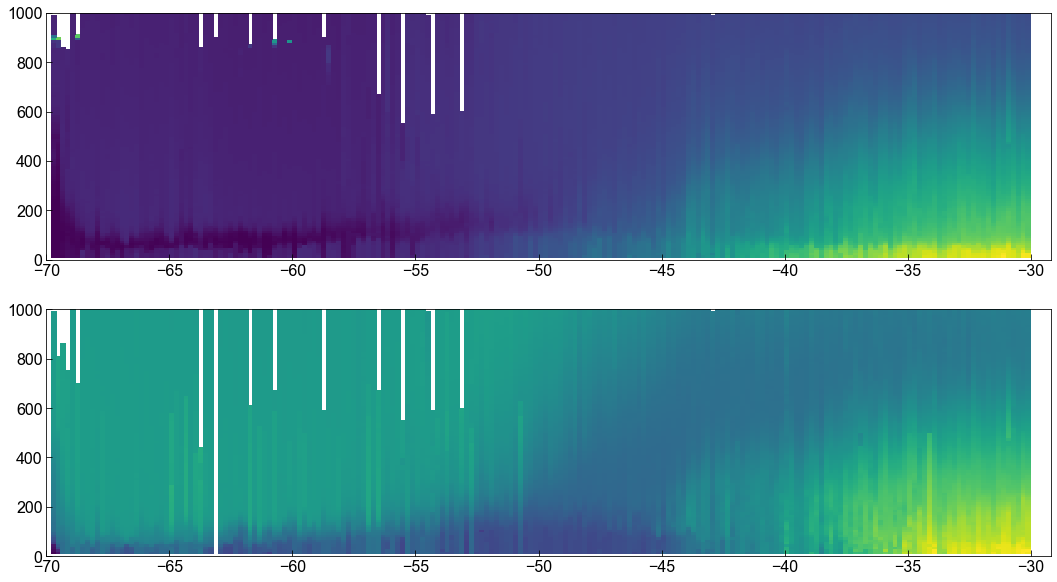

In [9]:
fig,ax=subplots(2)
ax[0].pcolormesh(new_lats, dpt, temp_grid)
ax[1].pcolormesh(new_lats, dpt, salt_grid)

#### Calculate the density from the T and S

In [10]:
dens = gsw.rho(salt_grid, temp_grid, p=0)

Calculate MLD

In [11]:
def calc_mld(dens, depth, thres=0.1):
    
    mld = np.ndarray(len(dens))
    
    for i in range(len(dens)):
        
        mld[i] = gt.physics.mixed_layer_depth(np.tile(0, 101), depth, dens[i], thresh=thres, ref_depth=20)
        
    return mld

In [12]:
mld = calc_mld(dens.T, dpt)

In [13]:
mld_new = gt.cleaning.rolling_window(mld, func=np.nanmedian, window=4)

(1000.0, 0.0)

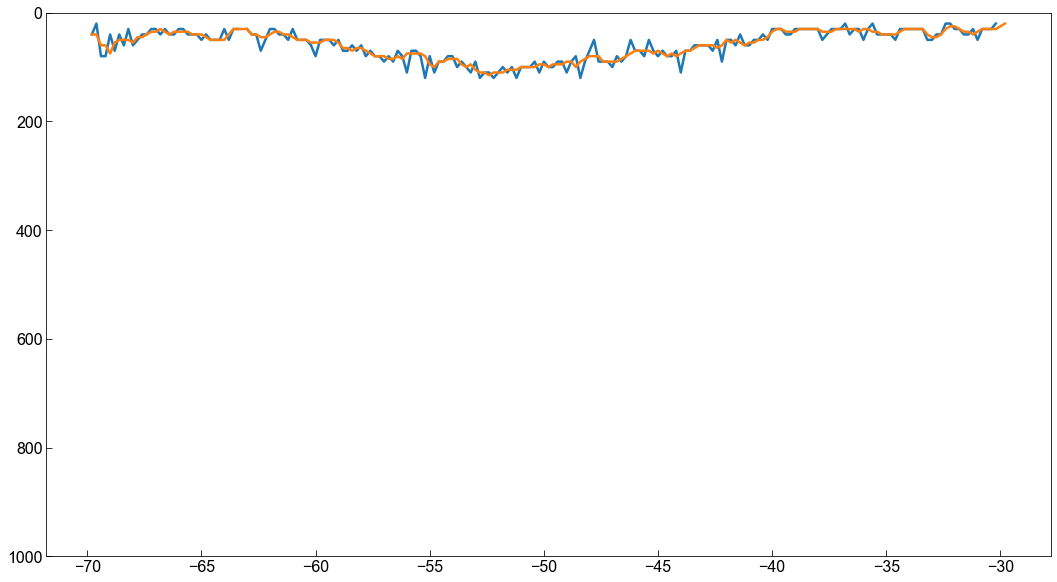

In [14]:
plot(new_lats, mld)
plot(new_lats, mld_new)

ylim(1000, 0)

In [15]:
dens_clean = np.ndarray(shape(dens))

for i in range(100):
    
    dens_clean[i] = gt.cleaning.rolling_window(dens[i], func=np.nanmedian, window=10)
#     dens_clean[:,i] = gt.cleaning.savitzky_golay(dens[:,i], window_size=35, order=11)


/Users/marcel/opt/anaconda3/lib/python3.8/site-packages/glidertools/helpers.py:70: GliderToolsWarning: Primary input variable is not xr.DataArray data type - no metadata to pass on.
  warnings.warn(msg, category=GliderToolsWarning)


Text(-41.5, 380, 'Density (kg m$^{-3}$)')

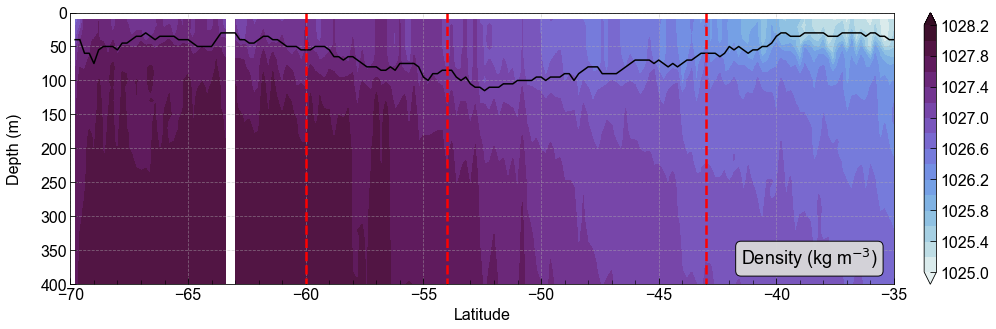

In [16]:
fig, ax = subplots(figsize=[18, 5])

h1 = ax.contourf(new_lats, dpt, dens, levels=np.arange(1025, 1028.2, 0.2), cmap=cmo.dense, extend='both')

colorbar(mappable=h1, ax=ax, pad=0.03)

ax.set_ylim(400, 0)
ax.set_xticks(np.arange(-70, -30, 1), minor=True)
ax.set_xlim(-70, -35) 
ax.grid(ls='--', alpha=0.5)

ax.plot(new_lats, mld_new, c='k', lw=1.5)

ax.plot([-60, -60], [0, 400], c='r', ls='--') 
ax.plot([-54, -54], [0, 400], c='r', ls='--') 
ax.plot([-43, -43], [0, 400], c='r', ls='--') 

ax.set_ylabel('Depth (m)', labelpad=18) 

ax.set_xlabel('Latitude')

props = dict(boxstyle='round', facecolor='0.85', alpha=0.95)

# place a text box in upper left in axes coords
ax.text(-41.5, 380, 'Density (kg m$^{-3}$)', fontsize=18,
        verticalalignment='bottom', bbox=props)



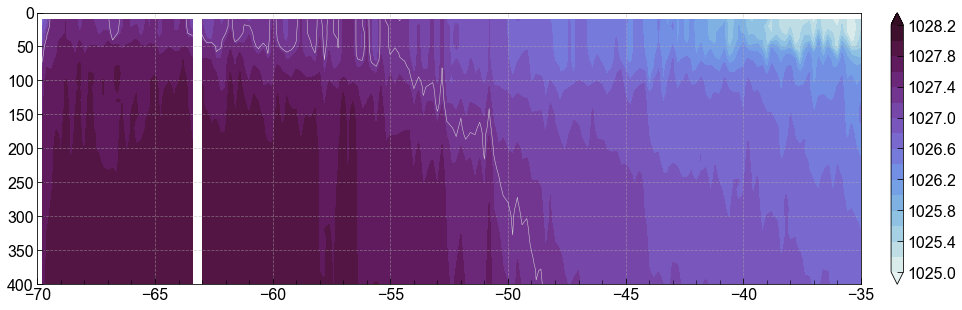

In [17]:
fig, ax = subplots(figsize=[18, 5])

h1 = ax.contourf(new_lats, dpt, dens, levels=np.arange(1025, 1028.2, 0.2), cmap=cmo.dense, extend='both')

colorbar(mappable=h1, ax=ax, pad=0.03)

ax.set_ylim(400, 0)
ax.set_xticks(np.arange(-70, -30, 1), minor=True)
ax.set_xlim(-70, -35) 
ax.grid(ls='--', alpha=0.5)

ax.contour(new_lats, dpt, dens, levels=[1027.3], colors='0.85', linewidths=0.5)


In [18]:
# CS=contour(new_lats, dpt, dens, levels=[1027.6], colors='0.5')
# dat0 = CS.allsegs[0][47]
# plt.plot(dat0[:,0],dat0[:,1], c='r')
# si = dat0

In [19]:
for i in range(len(CS.allsegs[0])):
    
    if i==0:
        lt = CS.allsegs[0][i][:,0]
        dp = CS.allsegs[0][i][:,1]
        
    if i>0:
        
        lt = np.append(lt, CS.allsegs[0][i][:,0])
        dp = np.append(dp, CS.allsegs[0][i][:,1])
    

NameError: name 'CS' is not defined

In [ ]:
i = np.argsort(lt)

lt = lt[i]
dp = dp[i]

In [ ]:
lt_new = np.arange(-70, -39, 0.1)
dp_new = griddata(lt, dp, lt_new)

In [ ]:
plot(lt, dp)
plot(lt_new, dp_new)
plot(lt_new, gt.cleaning.rolling_window(dp_new, func=np.nanmean, window=20))

### Plot the sections

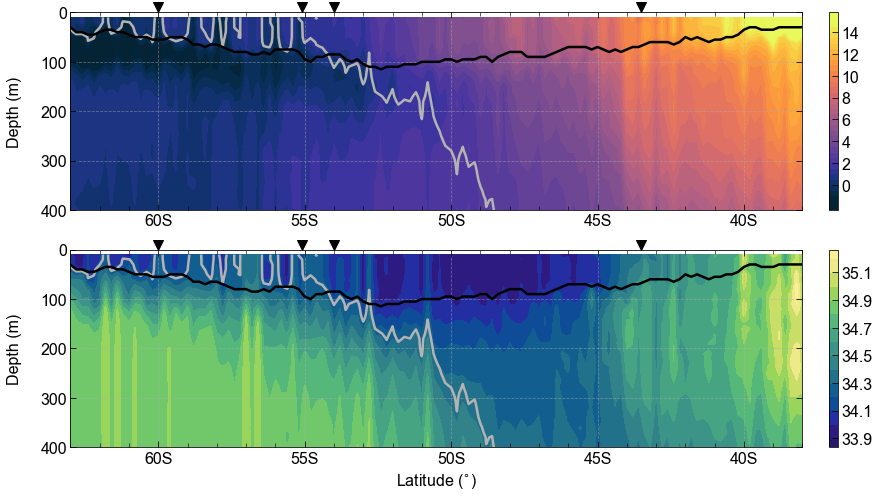

In [23]:
fig, ax = subplots(2, figsize=[16, 8])

h0 = ax[0].contourf(new_lats, dpt, temp_grid, levels=np.arange(-1.5, 15.5, 0.5), cmap=cmo.thermal, extend='both')
h1 = ax[1].contourf(new_lats, dpt, salt_grid, levels=np.arange(33.9, 35.2, 0.1), cmap=cmo.haline, extend='both')

colorbar(mappable=h0, ax=ax[0], pad=0.03, extendrect=True)
colorbar(mappable=h1, ax=ax[1], pad=0.03, extendrect=True)

[a.contour(new_lats, dpt, dens, levels=[1027.3], colors='0.7', linewidths=2.5) for a in ax]
# [a.plot(lt_new, gt.cleaning.rolling_window(dp_new, func=np.nanmin, window=3), color='0.7', linewidth=3) for a in ax]
# [a.plot(lt_new, dp_new, color='0.7', linewidth=2) for a in ax]

[a.set_ylim(400, 0) for a in ax]
[a.set_xticks(np.arange(-70, -30, 1), minor=True) for a in ax]
[a.set_xlim(-63, -38) for a in ax]
[a.grid(ls='--', alpha=0.5) for a in ax]

[a.plot(new_lats, mld_new, c='k', lw=2.5) for a in ax] # mixed layer depth

# [a.plot([-60, -60], [0, 400], c='r', ls='--') for a in ax]
# [a.plot([-54, -54], [0, 400], c='r', ls='--') for a in ax]
# [a.plot([-43, -43], [0, 400], c='r', ls='--') for a in ax]

[a.set_ylabel('Depth (m)', labelpad=18) for a in ax]

ax[1].set_xlabel('Latitude ($^{\circ}$)')

# fig.tight_layout()

props = dict(boxstyle='round', facecolor='0.85', alpha=0.95)

# place a text box in upper left in axes coords
# ax[0].text(-43, 380, '(a) Temperature ($^{\circ}$C)', fontsize=16,
#         verticalalignment='bottom', bbox=props)
# ax[1].text(-42.6, 380, '(b) Salinity (g kg$^{-1}$)', fontsize=16,
#         verticalalignment='bottom', bbox=props)

h= ax[0].scatter([-55.1, -43.5, -54, -60], [-10, -10, -10, -10], s=100, marker='v', c='k', zorder=10)
h.set_clip_on(False)

h= ax[1].scatter([-55.1, -43.5, -54, -60], [-10, -10, -10, -10], s=100, marker='v', c='k', zorder=10)
h.set_clip_on(False)

ax[0].yaxis.set_ticks_position('both')
ax[0].xaxis.set_ticks_position('both')

ax[1].yaxis.set_ticks_position('both')
ax[1].xaxis.set_ticks_position('both')

for i in range(2):
    ax[i].xaxis.set_ticks([-60, -55, -50, -45, -40])
    ax[i].xaxis.set_ticklabels(['60S', '55S', '50S', '45S', '40S'])


savefig('/Users/marcel/Google Drive/Projects/buoyancy_flux_paper/figures/en4_sections.png', dpi=300, bbox_inches='tight')